# **EMPLOYEE RETENTION PREDICTION**

## Install the library to the notebook

In [7]:
!pip install pandas numpy matplotlib seaborn scipy scikit-learn imbalanced-learn xgboost lightgbm optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.9 MB/s eta 0:00:00


## Install the downloded data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import*
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,precision_score,recall_score,f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


## loding The Data

In [4]:
import pandas as pd
df= pd.read_csv("aug_train.csv")

In [10]:
df.head(8)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
5,21651,city_176,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1,24,1.0
6,28806,city_160,0.920,Male,Has relevent experience,no_enrollment,High School,NaN,5,50-99,Funded Startup,1,24,0.0
7,402,city_46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0


In [11]:
# looking at the columns
df.columns.tolist()


['enrollee_id',
 'city',
 'city_development_index',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job',
 'training_hours',
 'target']

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

# Creating A Prerocessing Funtinon

In [13]:
# preprocessing in a singel function that can handle null , outliers , skewness , inbalance in data and feature engiering for categorical data

from imblearn.over_sampling import SMOTENC
import pandas as pd
import numpy as np

class Preprocessing:
    def __init__(self, df):
        self.df = df
        self.imputed_df = None
        self.balance_df = None
        self.featureEncoded_df = None
        self.target_mean_feature = []
        self.categorical_features_indices = []

    def handle_nulls(self):
        """Fill null values in specific columns."""
        self.df["enrolled_university"] = self.df["enrolled_university"].fillna("none")
        self.df["education_level"] = self.df["education_level"].fillna("Other")

        mode = self.df["experience"].mode()[0]
        self.df["experience"] = self.df["experience"].fillna(mode)

        self.df["last_new_job"] = self.df["last_new_job"].fillna("Not Specified")
        self.df['major_discipline'] = self.df['major_discipline'].fillna("Not_Specified")
        self.df["gender"] = self.df["gender"].fillna("Not_specified")
        self.df["company_size"] = self.df["company_size"].fillna("NS")
        self.df["company_type"] = self.df["company_type"].fillna("not_specified")
        self.imputed_df = self.df
        return self.df

    def encode_features(self):
        # Encode categorical features with target mean.
        features = ['gender', "enrolled_university", "major_discipline",
                    "education_level", "company_type", "city"]

        for i, feature in enumerate(features):
            self.target_mean_feature.append(self.df.groupby(feature)['target'].mean())
            self.df[feature] = self.df[feature].map(self.target_mean_feature[i])

        rel_exp={'Has relevent experience':1,'No relevent experience':0}
        # Map relevant experience to binary values.
        self.df["relevent_experience"] = self.df["relevent_experience"].map(rel_exp)

        # Map company size categories to numerical values using map().
        size_mapping = {'NS':1,'<10': 2,'10/49': 3,'50-99': 4,'100-500': 5,'500-999': 6,'1000-4999': 7,'5000-9999': 8,'10000+': 9}
        self.df["company_size"]=self.df["company_size"].map(size_mapping)


        # Map last new job categories to numerical values.

        u=df["last_new_job"].unique().tolist()
        un=[2,6,0,5,4,3,1]

        for i,j in zip(u,un):
          self.df["last_new_job"]=self.df["last_new_job"].replace(i,j)


        # Map experience categories to numerical values.

        experience_mapping = {'<1': 0,'1': 1,'2': 2,'3': 3,'4': 4,\
                              '5': 5,'6': 6,'7': 7,'8': 8,'9': 9,\
                              '10': 10,'11': 11,'12': 12,'13': 13,\
                              '14': 14,'15': 15,'16': 16,'17': 17,\
                              '18': 18,'19': 19,'20': 20,'>20': 21,}
        for i,j in zip(experience_mapping.keys(),experience_mapping.values()):
          self.df["experience"]=self.df["experience"].replace(i,j)

        self.featureEncoded_df = self.df
        return self.df



    def handle_outliers(self, features):
         # Handle outliers by capping them for specified features.
        for feature in features:
            Q1 = self.df[feature].quantile(0.25)
            Q3 = self.df[feature].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Cap the outliers
            self.df[feature] = np.where(self.df[feature] > upper_bound, upper_bound,
                                         np.where(self.df[feature] < lower_bound, lower_bound,
                                                  self.df[feature]))

        print("Outliers have been capped.")

        return self.df   # Return the modified DataFrame

    def handle_skewness(self, features):
        """Handle skewness using log transformation if necessary."""
        for feature in features:
            skewness_value = self.df[feature].skew()
            if skewness_value > 0.5:
                # Apply log transformation to reduce skewness
                self.df[feature] = np.log(self.df[feature] + 1)

        print("Skewness has been handled using log transformation where applicable.")

        return self.df   # Return the modified DataFrame

    def handle_imbalance(self):
        """Balance the dataset using SMOTENC."""
        X = self.df.drop("target", axis=1)
        y = self.df["target"]

        categorical_features_indices = [self.df.columns.get_loc(col) for col in['city', 'gender','relevent_experience',\
                                                                                'enrolled_university','education_level',\
                                                                                'major_discipline', 'experience',\
                                                                                'company_size', 'company_type',\
                                                                                'last_new_job']]

        smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=42)

        X_resampled, y_resampled = smote_nc.fit_resample(X, y)

        # Concatenate the resampled data back into a DataFrame
        self.balance_df = pd.concat([X_resampled, y_resampled], axis=1)

        # Store the balanced DataFrame back into self.df
        self.df = self.balance_df
        return self.balance_df

    def preprocess(self):
        """Run all preprocessing steps."""

        self.handle_nulls()
        self.handle_imbalance()
        self.encode_features()
        # Handle outliers and skewness
        self.handle_outliers(['training_hours', 'last_new_job', 'city_development_index',"gender","major_discipline","enrolled_university"])
        # self.handle_skewness(feature_list)



        return self.df   # Return processed DataFrame after encoding and balancing

# EDA

In [ ]:
# creatiung a copy of our data for EDA
eda = df.copy()
eda

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19153,7386,city_173,0.878,Male,No relevent experience,no_enrollment,Graduate,Humanities,14,NaN,NaN,1,42,1.0
19154,31398,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,NaN,NaN,4,52,1.0
19155,24576,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,4,44,0.0
19156,5756,city_65,0.802,Male,Has relevent experience,no_enrollment,High School,NaN,<1,500-999,Pvt Ltd,2,97,0.0


In [ ]:
# Check for null values
eda.isnull().sum()

,0
enrollee_id,0
city,0
city_development_index,0
gender,4508
relevent_experience,0
enrolled_university,386
education_level,460
major_discipline,2813
experience,65
company_size,5938


In [ ]:
# Handling null for EDA using self created preprocessing class
pre=Preprocessing(eda)
eda = pre.handle_nulls()

In [ ]:
# We have handled the null values so now we can create a EDA chared to understand the data
eda.isnull().sum()

,0
enrollee_id,0
city,0
city_development_index,0
gender,0
relevent_experience,0
enrolled_university,0
education_level,0
major_discipline,0
experience,0
company_size,0


In [ ]:
# checking categorical values
eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  19158 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     19158 non-null  object 
 6   education_level         19158 non-null  object 
 7   major_discipline        19158 non-null  object 
 8   experience              19158 non-null  object 
 9   company_size            19158 non-null  object 
 10  company_type            19158 non-null  object 
 11  last_new_job            19158 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

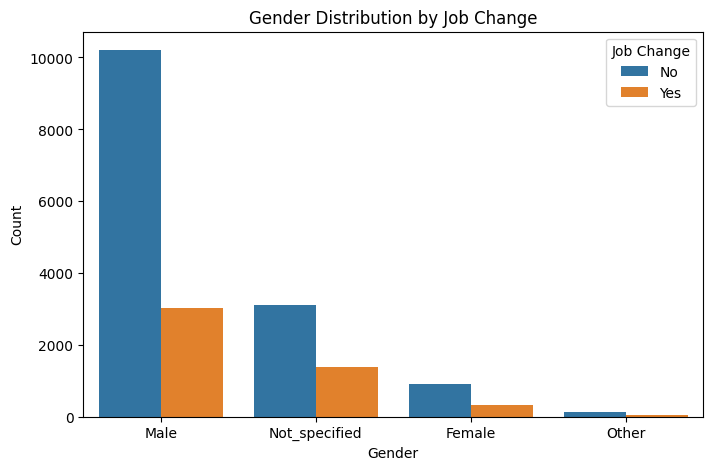

In [ ]:
# 1. Gender Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='gender', hue='target', data=eda)
plt.title('Gender Distribution by Job Change')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Job Change', loc='upper right', labels=['No', 'Yes'])
plt.show()
## The null valued are imputed as a new class( not specified ) because the missing values are 25% to 30%

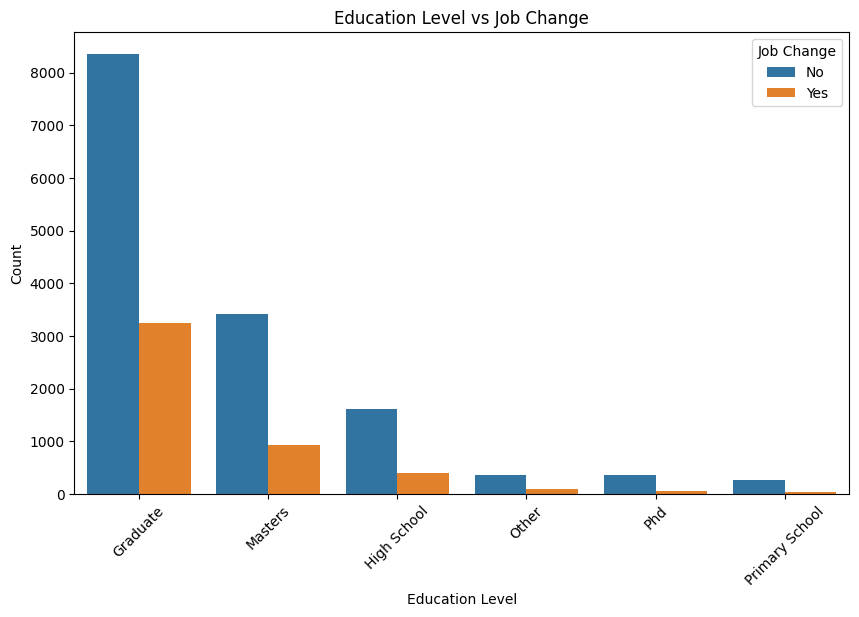

In [ ]:
# 2. Education Level vs Job Change
plt.figure(figsize=(10, 6))
sns.countplot(x='education_level', hue='target', data=eda)
plt.title('Education Level vs Job Change')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Job Change', loc='upper right', labels=['No', 'Yes'])
plt.show()
# The null valued are imputed as a new class( Other ) because of signification of the feature

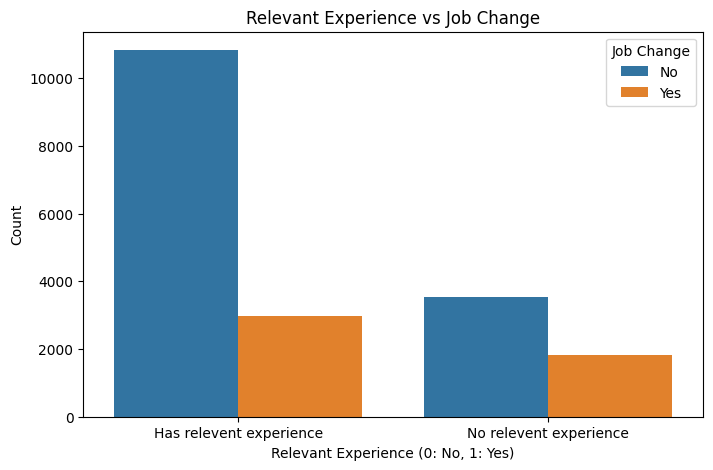

In [ ]:
# 3. Relevant Experience vs Job Change
plt.figure(figsize=(8, 5))
sns.countplot(x='relevent_experience', hue='target', data=eda)
plt.title('Relevant Experience vs Job Change')
plt.xlabel('Relevant Experience (0: No, 1: Yes)')
plt.ylabel('Count')
plt.legend(title='Job Change', loc='upper right', labels=['No', 'Yes'])
plt.show()


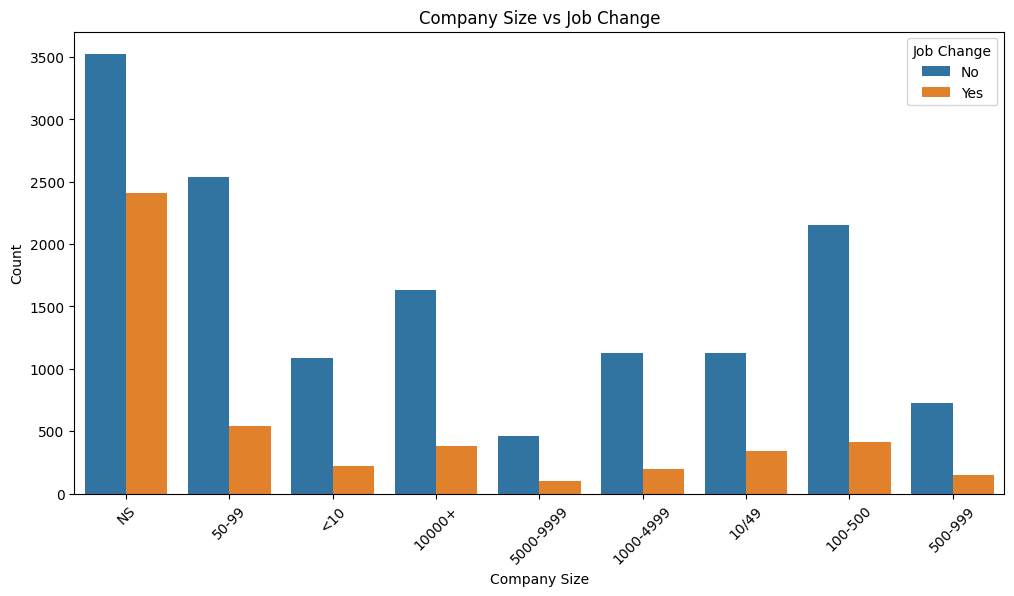

In [ ]:
# 4. Company Size vs Job Change
plt.figure(figsize=(12, 6))
sns.countplot(x='company_size', hue='target', data=eda)
plt.title('Company Size vs Job Change')
plt.xlabel('Company Size')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Job Change', loc='upper right', labels=['No', 'Yes'])
plt.show()
# The null valued are imputed as a new class( NS ) because the missing values are more than 30%

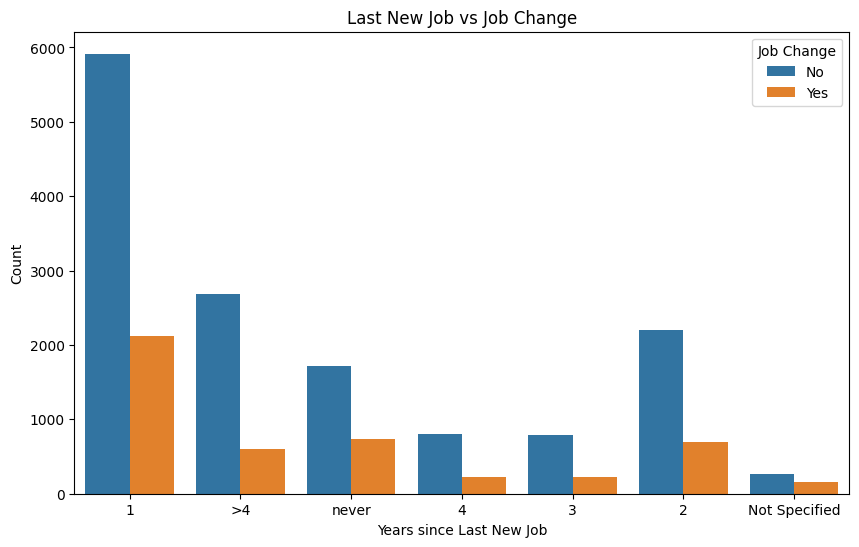

In [ ]:
# 5. Last New Job vs Job Change
plt.figure(figsize=(10, 6))
sns.countplot(x='last_new_job', hue='target', data=eda)
plt.title('Last New Job vs Job Change')
plt.xlabel('Years since Last New Job')
plt.ylabel('Count')
plt.legend(title='Job Change', loc='upper right', labels=['No', 'Yes'])
plt.show()
## The null valued are imputed as a new class( Not Specified ) because the missing values are more than 30%

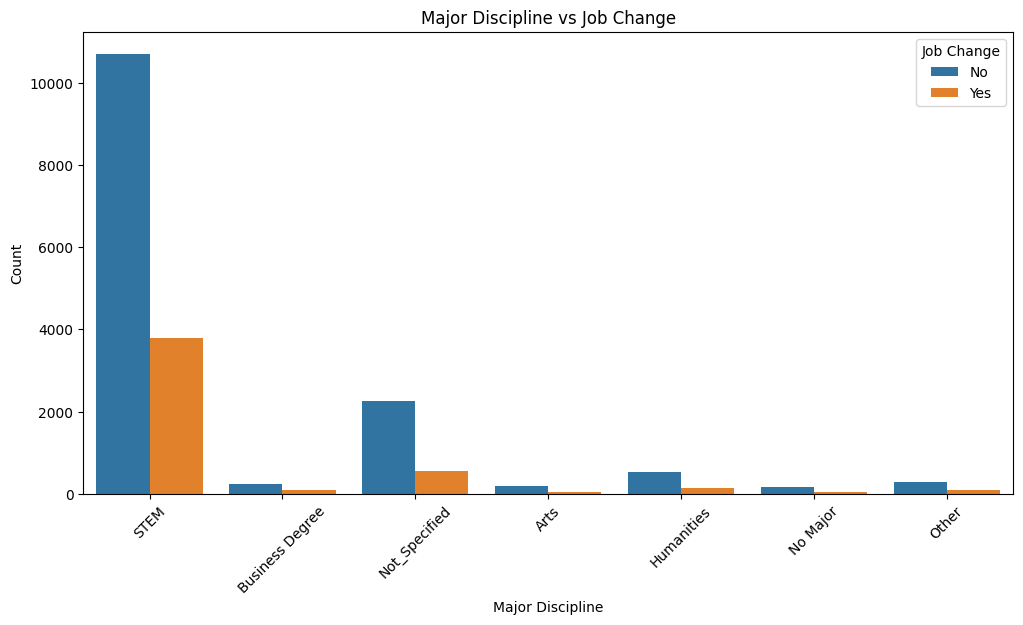

In [ ]:
# 6. Major Discipline vs Job Change
plt.figure(figsize=(12, 6))
sns.countplot(x='major_discipline', hue='target', data=eda)
plt.title('Major Discipline vs Job Change')
plt.xlabel('Major Discipline')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Job Change', loc='upper right', labels=['No', 'Yes'])
plt.show()
## The null valued are imputed as a new class( Not_Specified ) because the missing values are more than 30%

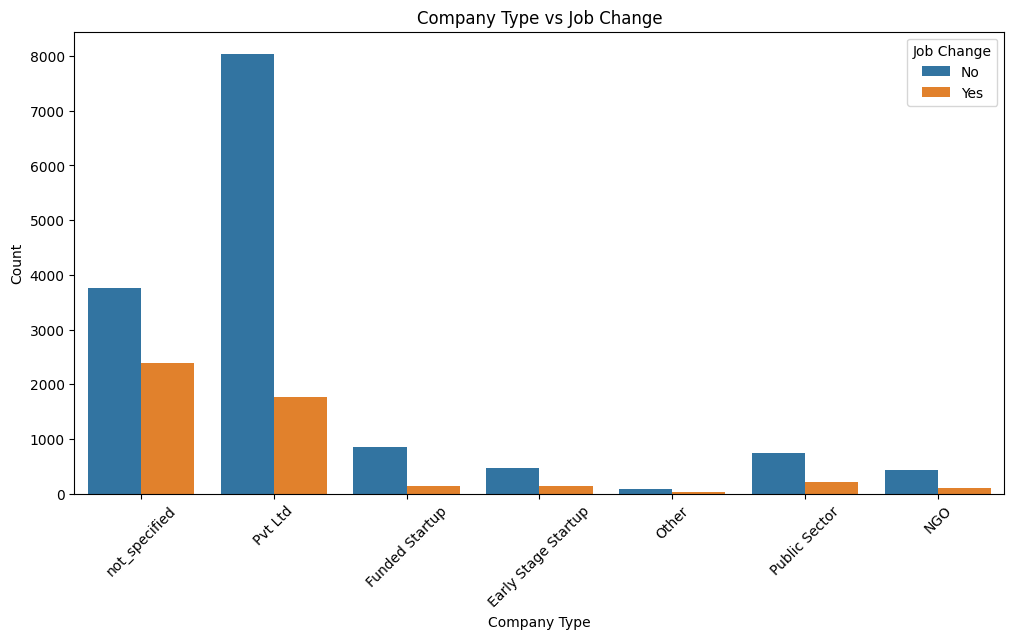

In [ ]:
# 7. Company Type vs Job Change
plt.figure(figsize=(12, 6))
sns.countplot(x='company_type', hue='target', data=eda)
plt.title('Company Type vs Job Change')
plt.xlabel('Company Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Job Change', loc='upper right', labels=['No', 'Yes'])
plt.show()
## The null valued are imputed as a new class( not_specified ) because the missing values are more than 30%

In [ ]:
# creating a dic and storing the unique values and its frequency
ValueCount = {}
for column in df.columns:
  if df[column].dtype == 'object':  # Check if the column is categorical (object type)
    ValueCount[column] = df[column].value_counts().to_dict()


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# Function to convert experience and last_new_job to numeric
def convert_to_numeric(value):
    if isinstance(value, str):
        if value == '>20':
            return 21
        elif value == '<1':
            return 0
        elif value == 'never':
            return 0
        elif value.isdigit():
            return int(value)
    return np.nan

# Apply conversion function to relevant columns
eda['experience'] = eda['experience'].apply(convert_to_numeric)
eda['last_new_job'] = eda['last_new_job'].apply(convert_to_numeric)

# Function to detect outliers using IQR method and Z-score method
def detect_outliers(EDA, feature):
    # IQR Method
    Q1 = eda[feature].quantile(0.25)
    Q3 = eda[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers using IQR
    outliers_iqr = eda[(eda[feature] < lower_bound) | (eda[feature] > upper_bound)]

    # Z-Score Method
    z_scores = np.abs(stats.zscore(eda[feature].dropna()))

    # Create a boolean mask for the original DataFrame's index
    mask = np.zeros(len(eda), dtype=bool)
    mask[eda[feature].dropna().index] = (z_scores > 3)

    outliers_z = eda[mask]

    return outliers_iqr, outliers_z



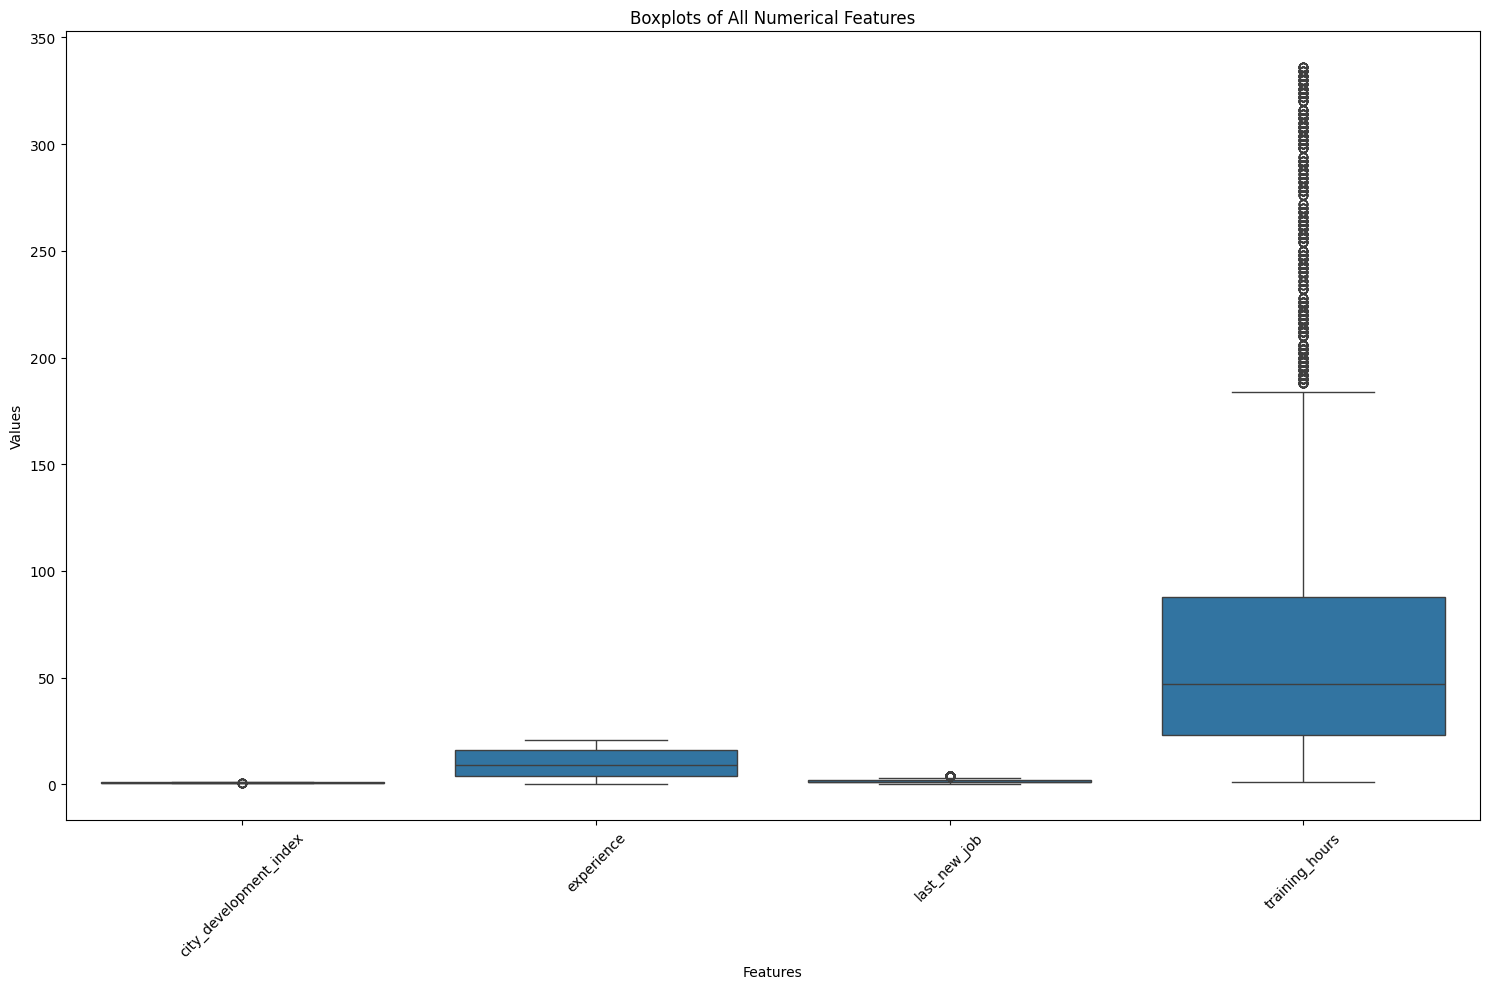

In [ ]:
# Remove the 'enrollee_id' and 'target' columns
x = eda.drop(['enrollee_id', 'target'],axis=1)

# Select numerical features
numerical_features = x.select_dtypes(include=['float64', 'int64']).columns

# Melt the DataFrame to long format for seaborn
melted_df = x[numerical_features].melt(var_name='Feature', value_name='Values')

# Create a boxplot for all numerical features in a single graph
plt.figure(figsize=(15, 10))
sns.boxplot(x='Feature', y='Values', data=melted_df)
plt.title('Boxplots of All Numerical Features')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.ylabel('Values')
plt.xlabel('Features')

plt.tight_layout()
plt.show()

# we see the training_hours is having high outliers values

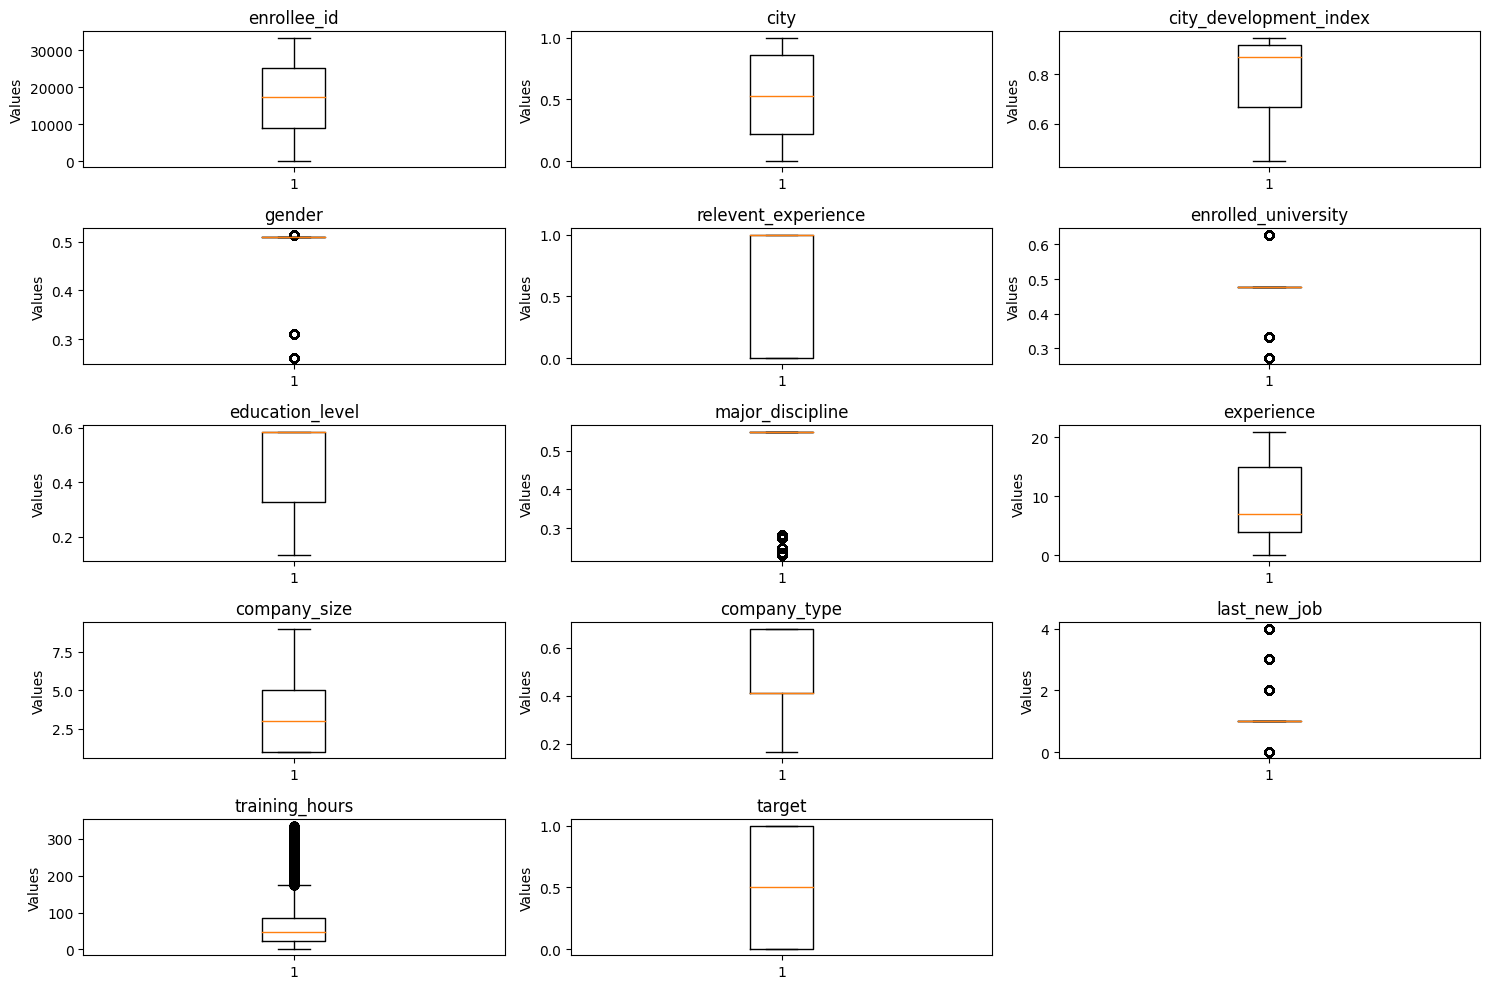

In [ ]:
eda = pre.handle_imbalance()
eda = pre.encode_features()

# Select numerical features
numerical_features = eda.select_dtypes(include=['float64', 'int64']).columns

# Create boxplots for each numerical feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(len(numerical_features)//3 + 1, 3, i + 1)
    plt.boxplot(eda[feature].dropna())  # Drop NaN values for plotting
    plt.title(feature)
    plt.ylabel('Values')

plt.tight_layout()
plt.show()

<ipython-input-47-535e7b17cf3f>:56: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df["last_new_job"]=self.df["last_new_job"].replace(i,j)
<ipython-input-47-535e7b17cf3f>:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df["experience"]=self.df["experience"].replace(i,j)


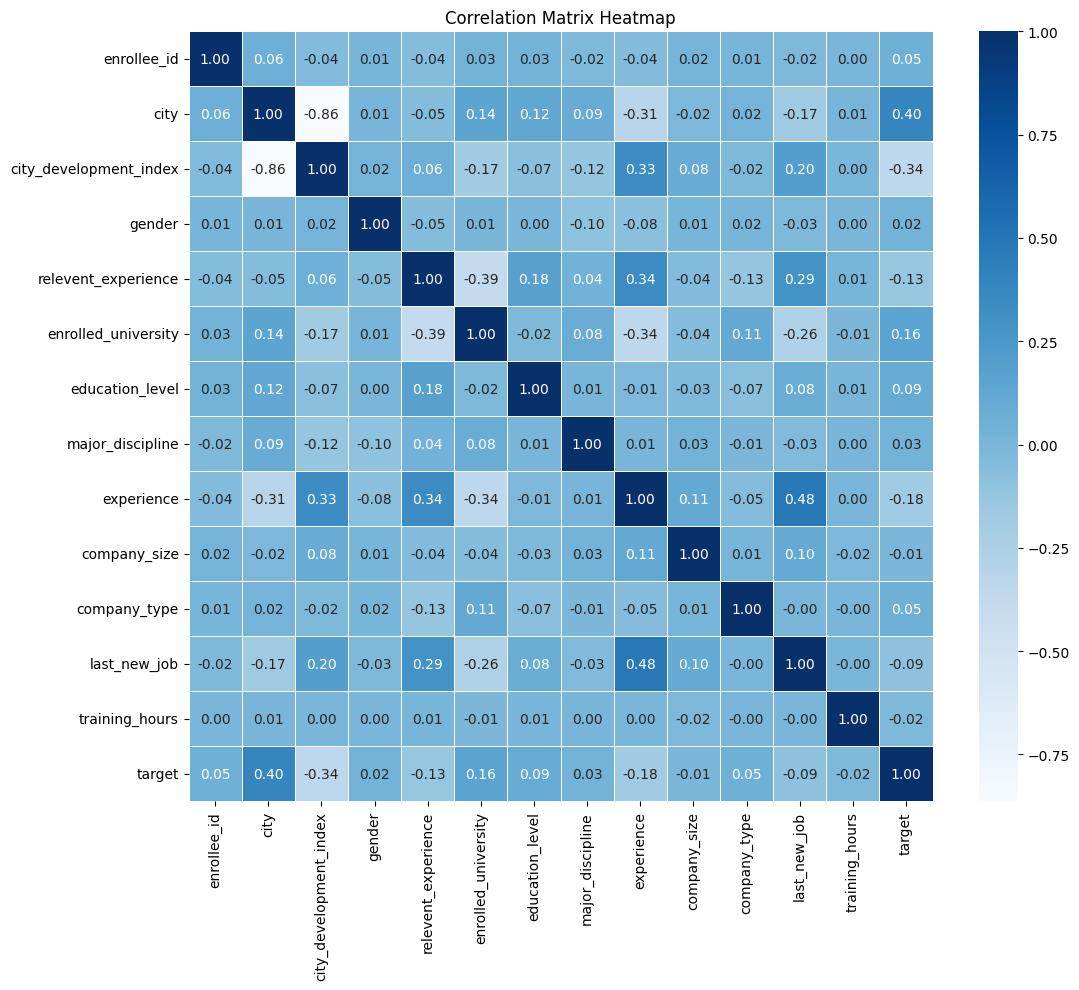

In [ ]:
# encoding the categorical data to numerical so that we can creat heatmap to see the corrrelation between the features
c_df=df.copy()
pre = Preprocessing(c_df)
data = pre.encode_features()

# creating a corrrelation matrix
correlation_matrix = data.corr()

# Create a heatmap with annotations and blue color map
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

## correlation in decending order

  city > company_type > education_level > major_disipline > gender > endrollee_id > training_hour > relevent_experience > last_new_job > experence > company_size > city_development_index  

# Preprocessing the data

In [ ]:
# function in the top

In [14]:
df.isnull().sum()

,0
enrollee_id,0
city,0
city_development_index,0
gender,4508
relevent_experience,0
enrolled_university,386
education_level,460
major_discipline,2813
experience,65
company_size,5938


In [15]:
pre_pross = Preprocessing(df)
df=pre_pross.preprocess()

Outliers have been capped.


<ipython-input-13-535e7b17cf3f>:56: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df["last_new_job"]=self.df["last_new_job"].replace(i,j)
<ipython-input-13-535e7b17cf3f>:67: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df["experience"]=self.df["experience"].replace(i,j)


In [16]:
# checking for null values
df.isnull().sum()

,0
enrollee_id,0
city,0
city_development_index,0
gender,0
relevent_experience,0
enrolled_university,0
education_level,0
major_discipline,0
experience,0
company_size,0


In [26]:
df

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,0.525281,0.920000,0.511016,1,0.477886,0.586342,0.548767,21,1,0.681263,2.0,36.0,1.0
1,29725,0.309524,0.776000,0.511016,0,0.477886,0.586342,0.548767,15,4,0.410194,4.5,47.0,0.0
2,11561,0.857658,0.624000,0.509899,0,0.477886,0.586342,0.548767,5,1,0.681263,0.5,83.0,0.0
3,33241,0.500000,0.789000,0.509899,0,0.477886,0.586342,0.548767,0,1,0.410194,0.5,52.0,1.0
4,666,0.434783,0.767000,0.511016,1,0.477886,0.326386,0.548767,21,4,0.163265,4.5,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28757,21952,0.857658,0.652873,0.511016,1,0.477886,0.586342,0.548767,8,5,0.410194,4.0,17.0,1.0
28758,2198,0.857658,0.764499,0.511016,1,0.477886,0.586342,0.548767,14,4,0.410194,4.5,68.0,1.0
28759,28092,0.525281,0.920000,0.511016,1,0.477886,0.586342,0.548767,21,1,0.681263,2.0,101.0,1.0
28760,5555,0.857658,0.699495,0.509899,1,0.477886,0.326386,0.548767,6,1,0.410194,2.0,147.0,1.0


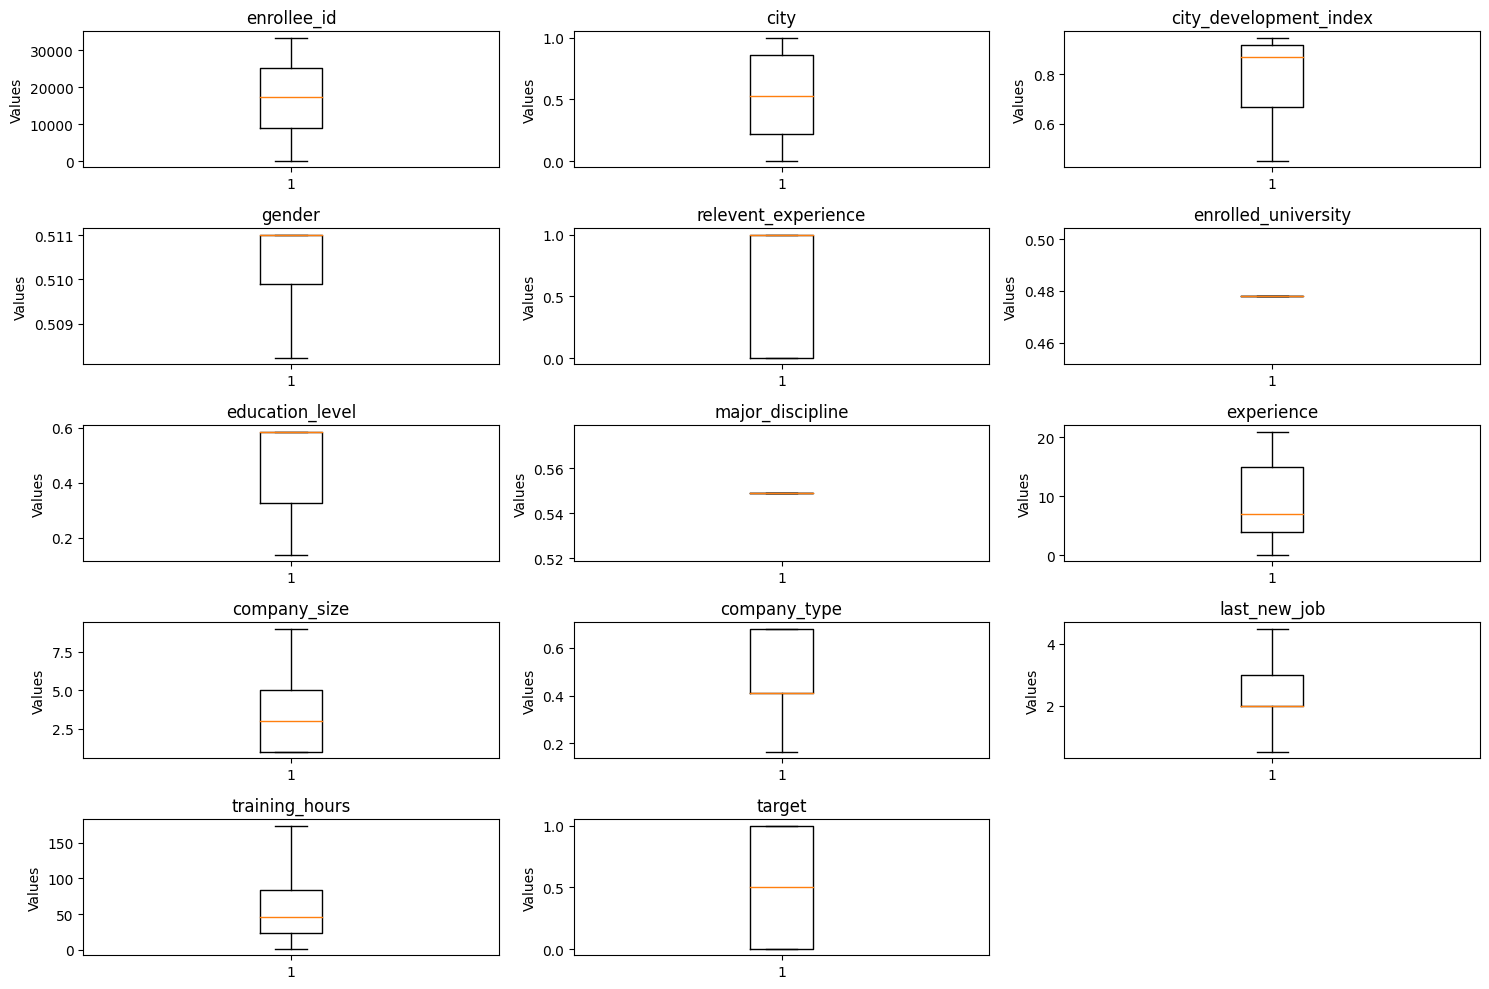

In [18]:

# creating box plot for all the feature
# Select numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

# Create boxplots for each numerical feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(len(numerical_features)//3 + 1, 3, i + 1)
    plt.boxplot(df[feature].dropna())  # Drop NaN values for plotting
    plt.title(feature)
    plt.ylabel('Values')

plt.tight_layout()
plt.show()

In [19]:
# checking the balance data set
df["target"].value_counts()

,count
target,
1.0,14381
0.0,14381


In [20]:
# checking for feature engineerig of categorical values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28762 entries, 0 to 28761
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             28762 non-null  int64  
 1   city                    28762 non-null  float64
 2   city_development_index  28762 non-null  float64
 3   gender                  28762 non-null  float64
 4   relevent_experience     28762 non-null  int64  
 5   enrolled_university     28762 non-null  float64
 6   education_level         28762 non-null  float64
 7   major_discipline        28762 non-null  float64
 8   experience              28762 non-null  int64  
 9   company_size            28762 non-null  int64  
 10  company_type            28762 non-null  float64
 11  last_new_job            28762 non-null  float64
 12  training_hours          28762 non-null  float64
 13  target                  28762 non-null  float64
dtypes: float64(10), int64(4)
memory usage:

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

def evaluate_models(df):
    # Split the data into training and testing sets
    X = df.drop(columns=["target"])
    y = df["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define models
    models = {
        "LogisticRegression": LogisticRegression(),
        "RandomForestClassifier": RandomForestClassifier(random_state=24),
        "XGBoost": XGBClassifier(random_state=24),
        "LightGBM": LGBMClassifier(verbosity=-1)
    }

    # Initialize a list to store metrics
    metrics_list = []

    # Plotting ROC curves
    plt.figure(figsize=(10, 8))

    # Iterate through models
    for model_name, model in models.items():
        model.fit(X_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Collect metrics for training
        metrics_train = {
            'Model': model_name,
            'Accuracy_Train': accuracy_score(y_train, y_train_pred),
            'Precision_Train': precision_score(y_train, y_train_pred, average='weighted', zero_division=0),
            'Recall_Train': recall_score(y_train, y_train_pred, average='weighted', zero_division=0),
            'F1_Score_Train': f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
        }

        # Check if the model supports ROC AUC score calculation and plotting ROC curve
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
            metrics_train['AUC_ROC_Train'] = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

            # Compute ROC curve
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {metrics_train["AUC_ROC_Train"]:.2f})')

        else:
            warnings.warn(f"{model_name} does not support probability predictions for ROC AUC.")

        # Collect metrics for testing
        metrics_test = {
            'Accuracy_Test': accuracy_score(y_test, y_test_pred),
            'Precision_Test': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
            'Recall_Test': recall_score(y_test, y_test_pred, average='weighted', zero_division=0),
            'F1_Score_Test': f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
        }

        if hasattr(model, "predict_proba"):
            metrics_test['AUC_ROC_Test'] = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        else:
            warnings.warn(f"{model_name} does not support probability predictions for ROC AUC.")

        # Combine train and test metrics into one dictionary
        combined_metrics = {**metrics_train, **metrics_test}

        # Append to the list
        metrics_list.append(combined_metrics)

    # Create a DataFrame from the list of metrics
    metrics_df = pd.DataFrame(metrics_list)

    # Plotting details for ROC curve
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for random guess
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    return metrics_df

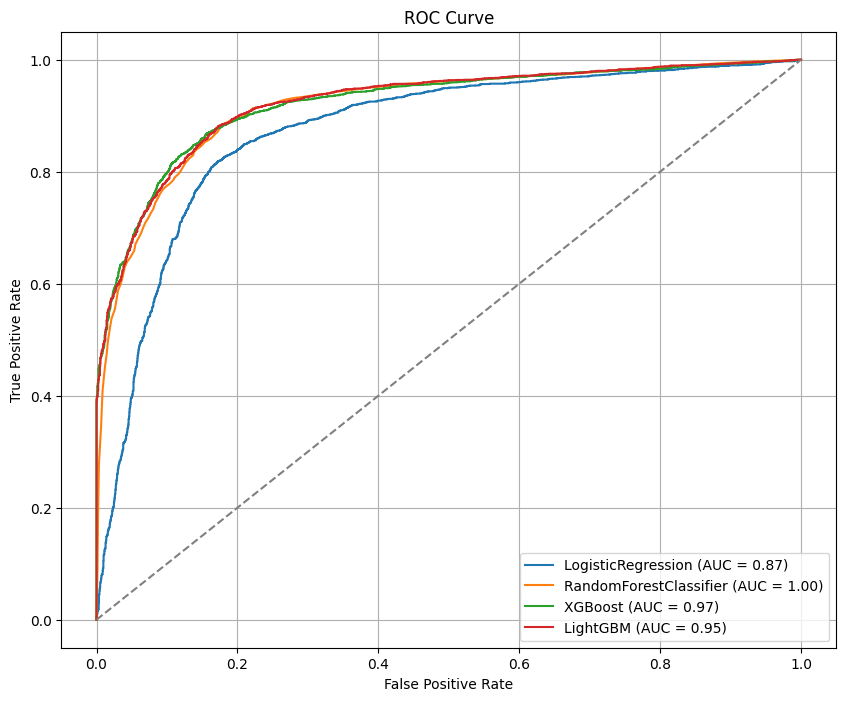

,Model,Accuracy_Train,Precision_Train,Recall_Train,F1_Score_Train,AUC_ROC_Train,Accuracy_Test,Precision_Test,Recall_Test,F1_Score_Test,AUC_ROC_Test
0,LogisticRegression,0.824895,0.824918,0.824895,0.824891,0.872293,0.821832,0.821892,0.821832,0.821824,0.873684
1,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,0.849644,0.849662,0.849644,0.849642,0.918971
2,XGBoost,0.909253,0.909266,0.909253,0.909252,0.973953,0.853815,0.853819,0.853815,0.853815,0.922278
3,LightGBM,0.872702,0.872830,0.872702,0.872691,0.948770,0.853120,0.853459,0.853120,0.853085,0.923356


In [22]:
metrics_df = evaluate_models(df)
metrics_df

## **Inference From The Model**

  - LogisticRegression is performing average
  - RandomForestClassifier is over-fitting(memorizing data)
  - XGBoost is good in both trian and test
  - LightGBM is the second to XGBoost and better than RandomForestClassifier and LogisticRegression    




# Hyperparameter Tuning
  - Hyperparameters: External settings that control learning.
  - Importance: Optimize model performance, prevent overfitting/underfitting.
  - Methods: Grid search, random search, Bayesian optimization, gradient-based optimization,optuna.
  - Challenges: Can be computationally expensive.

In [27]:
# Split the data into training and testing sets
X = df.drop(columns=["target"])
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Added train_test_split


## Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators":[200,400,600],
    "max_depth":[1,2,3,4],
    "min_samples_split":[2,4],
    "min_samples_leaf":[2,4],
}
# random forest model
rd = RandomForestClassifier()
# grid search cv model
grid_search = GridSearchCV(estimator=rd,param_grid=param_grid,cv=10,scoring="accuracy")
grid_search.fit(X_train,y_train) # train the model

print(grid_search.best_estimator_) # print the best estimator
print(grid_search.best_params_) # print the best parameters
print(grid_search.best_score_) # print the best score



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomForestClassifier(max_depth=4, min_samples_leaf=4, min_samples_split=4,
                       n_estimators=200)
{'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 200}
0.8360205392740397


In [ ]:
import optuna

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Create and train the Random Forest model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    model.fit(X_train, y_train)

    # Make predictions and evaluate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and their corresponding accuracy
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2024-10-24 17:40:30,144] A new study created in memory with name: no-name-8e973fb1-d7a0-40b6-a501-9a98a13b8272
[I 2024-10-24 17:40:32,560] Trial 0 finished with value: 0.8487745524074396 and parameters: {'n_estimators': 118, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8487745524074396.
[I 2024-10-24 17:40:35,051] Trial 1 finished with value: 0.8446028159221276 and parameters: {'n_estimators': 165, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.8487745524074396.
[I 2024-10-24 17:40:36,973] Trial 2 finished with value: 0.849122197114549 and parameters: {'n_estimators': 67, 'max_depth': 13, 'min_samples_split': 16, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.849122197114549.
[I 2024-10-24 17:40:41,430] Trial 3 finished with value: 0.8486007300538849 and parameters: {'n_estimators': 157, 'max_depth': 15, 'min_samples_split': 18, 'min_samples_leaf': 15}. Best is trial 2 with valu

Best hyperparameters: {'n_estimators': 61, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 2}
Best accuracy: 0.8545106900747436


#best parameter

  pass 1:

    RandomForestClassifier(max_depth=4, min_samples_leaf=4, min_samples_split=4,
                          n_estimators=400)
    {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 400}
    0.8358032235511971

  pass2:

    RandomForestClassifier(max_depth=4, min_samples_leaf=4, min_samples_split=4,
                          n_estimators=700)
    {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 700}
    0.8359771554900517

  pass3:

    Best hyperparameters: {'n_estimators': 190, 'max_depth': 32, 'min_samples_split': 3, 'min_samples_leaf': 1}
    Best accuracy: 0.8555536241960716

# XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter Tuning for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [300,400,500],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# XGBoost model
xgb = XGBClassifier()

# Grid search CV model for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)  # Train the model

print("Best XGBoost Estimator:", grid_search_xgb.best_estimator_)
print("Best XGBoost Parameters:", grid_search_xgb.best_params_)
print("Best XGBoost Score:", grid_search_xgb.best_score_)

Best XGBoost Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.8}
Best XGBoost Score: 0.854926262180028


In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    # Create and train the XGBoost model
    model = XGBClassifier(
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        n_estimators=100,
        random_state=42
    )

    model.fit(X_train, y_train)

    # Make predictions and evaluate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and their corresponding accuracy
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2024-10-24 18:03:29,480] A new study created in memory with name: no-name-eb900573-ed79-485a-9ff1-98a8f10641db
[I 2024-10-24 18:03:29,662] Trial 0 finished with value: 0.8482530853467756 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.5521761260597069, 'colsample_bytree': 0.8563523614192257}. Best is trial 0 with value: 0.8482530853467756.
[I 2024-10-24 18:03:29,866] Trial 1 finished with value: 0.8486007300538849 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.5055834322867432, 'colsample_bytree': 0.9524887690624169}. Best is trial 1 with value: 0.8486007300538849.
[I 2024-10-24 18:03:30,191] Trial 2 finished with value: 0.8505127759429862 and parameters: {'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.6743427069294041, 'colsample_bytree': 0.5580361102611355}. Best is trial 2 with value: 0.8505127759429862.
[I 2024-10-24 18:03:30,459] Trial 3 finished with value: 0.851729532417869 and parameters: {'max_depth': 5, 'min_child_weigh

Best hyperparameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.7862452694620238, 'colsample_bytree': 0.6633512572560821}
Best accuracy: 0.8550321571354076


# best param

pass1:

    Best XGBoost Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
    Best XGBoost Score: 0.8556215553541117

pass2:

    Best XGBoost Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}
    Best XGBoost Score: 0.8554912528227099

pass3:
    
    Best hyperparameters: {'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.9048628638435, 'colsample_bytree': 0.5853316948275066}
    Best accuracy: 0.8557274465496263

# LogisticRegression

In [34]:
from sklearn.model_selection import GridSearchCV


# Hyperparameter Tuning for Logistic Regression
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1,0.5,1,5,10],
    'solver': ['lbfgs', 'liblinear','newton-cg', 'newton-cholesky']
}

# Logistic Regression model
lr = LogisticRegression(max_iter=1000)

# Grid search CV model for Logistic Regression
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_lr.fit(X_train, y_train)  # Train the model

print("Best Logistic Regression Estimator:", grid_search_lr.best_estimator_)
print("Best Logistic Regression Parameters:", grid_search_lr.best_params_)
print("Best Logistic Regression Score:", grid_search_lr.best_score_)

Best Logistic Regression Estimator: LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='liblinear')
Best Logistic Regression Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best Logistic Regression Score: 0.8230256143889509


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
105 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/

## best paramater

pass1:

        Best Logistic Regression Estimator: LogisticRegression(C=0.01, max_iter=1000, penalty='l1', solver='liblinear')
        Best Logistic Regression Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
        Best Logistic Regression Score: 0.8295448970383307

pass2:

        Best Logistic Regression Estimator: LogisticRegression(C=0.5, max_iter=1000)
        Best Logistic Regression Parameters: {'C': 0.5, 'penalty': 'l2', 'solver': 'lbfgs'}
        Best Logistic Regression Score: 0.8291101994814157


# LightGBM

In [28]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters for LightGBM
    num_leaves = trial.suggest_int('num_leaves', 20, 150)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', -1, 10)  # -1 means no limit

    # Create and train the LightGBM model
    model = LGBMClassifier(
        num_leaves=num_leaves,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )

    model.fit(X_train, y_train)

    # Make predictions and evaluate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and their corresponding accuracy
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2024-10-25 10:27:48,696] A new study created in memory with name: no-name-027d6b0c-781a-4070-b7b9-b9880bd63275
[I 2024-10-25 10:27:49,878] Trial 0 finished with value: 0.8536415783069703 and parameters: {'num_leaves': 138, 'learning_rate': 0.040570185419942784, 'n_estimators': 180, 'max_depth': 9}. Best is trial 0 with value: 0.8536415783069703.
[I 2024-10-25 10:27:50,376] Trial 1 finished with value: 0.853815400660525 and parameters: {'num_leaves': 118, 'learning_rate': 0.11274236159079724, 'n_estimators': 125, 'max_depth': 6}. Best is trial 1 with value: 0.853815400660525.
[I 2024-10-25 10:27:50,737] Trial 2 finished with value: 0.8508604206500956 and parameters: {'num_leaves': 76, 'learning_rate': 0.2577476870028623, 'n_estimators': 70, 'max_depth': 9}. Best is trial 1 with value: 0.853815400660525.
[I 2024-10-25 10:27:51,434] Trial 3 finished with value: 0.8487745524074396 and parameters: {'num_leaves': 25, 'learning_rate': 0.014007888347366411, 'n_estimators': 187, 'max_depth':

Best hyperparameters: {'num_leaves': 118, 'learning_rate': 0.18353999594031392, 'n_estimators': 145, 'max_depth': 7}
Best accuracy: 0.858508604206501


In [32]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [20, 40, 100]
}

# Create a LightGBM classifier
lgbm = lgb.LGBMClassifier(verbosity = -1)

# Set up GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid,
                           scoring='accuracy', cv=5, n_jobs=-1)

# Fit GridSearchCV to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best parameters from GridSearchCV
print("Best LGBMClassifier Estimator:", grid_search.best_estimator_)
print("Best LGBMClassifier Parameters:", grid_search.best_params_)
print("Best LGBMClassifier Score:", grid_search.best_score_)


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best LGBMClassifier Estimator: LGBMClassifier(max_depth=20, num_leaves=50, verbosity=-1)
Best LGBMClassifier Parameters: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 50}
Best LGBMClassifier Score: 0.8547957235077573


## best paramater

pass1:

      Best LGBMClassifier Estimator: LGBMClassifier(max_depth=20, num_leaves=50, verbosity=-1)
      Best LGBMClassifier Parameters: {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 100, 'num_leaves': 50}
      Best LGBMClassifier Score: 0.8547957235077573

pass3:

        Best hyperparameters: {'num_leaves': 118, 'learning_rate': 0.18353999594031392, 'n_estimators': 145, 'max_depth': 7}
        Best accuracy: 0.858508604206501

pass3:

        Best hyperparameters: {'num_leaves': 118, 'learning_rate': 0.18353999594031392, 'n_estimators': 145, 'max_depth': 7}
        Best accuracy: 0.858508604206501

# Hypermater tuning score

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["target"])
y = df["target"]

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [36]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import optuna
from sklearn.preprocessing import StandardScaler

def hyperparam_models(data, target_column):
    # Split the DataFrame into features and target variable
    X = data.drop(columns=[target_column])
    y = data[target_column]

    # Split data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define models and their hyperparameters for GridSearchCV
    models = {
        "LogisticRegression": {
            "model": LogisticRegression(),
            "params": {
                'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10],
                'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']
            },
            "use_optuna": False
        },
        "RandomForestClassifier": {
            "model": RandomForestClassifier(random_state=24),
            "params": {
                "max_depth": [1, 2, 3, 4],
                "min_samples_split": [2, 4],
                "min_samples_leaf": [2, 4],
            },
            "use_optuna": False
        },
        "XGBoost": {
            "model": XGBClassifier(random_state=24),
            "params": None,
            "use_optuna": True
        },
        "LightGBM": {
            "model": LGBMClassifier(verbosity=-1),
            "params": None,
            "use_optuna": True
        }
    }

    # Initialize lists to store metrics and best parameters
    gridsearch_metrics_list = []
    optuna_metrics_list = []
    best_params_list = []

    # Iterate through models
    for model_name, model_info in models.items():
        model = model_info["model"]

        if model_info["use_optuna"]:
            # Define the objective function for Optuna
            def objective(trial):
                if model_name == "XGBoost":
                    param = {
                        'max_depth': trial.suggest_int('max_depth', 1, 10),
                        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
                    }
                    model.set_params(**param)
                elif model_name == "LightGBM":
                    param = {
                        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
                        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                        'n_estimators': trial.suggest_int('n_estimators', 50, 200)
                    }
                    model.set_params(**param)

                # Fit the model and return accuracy as the objective value
                model.fit(X_train, y_train)
                return accuracy_score(y_test, model.predict(X_test))

            # Create an Optuna study and optimize the objective function
            study = optuna.create_study(direction='maximize')
            study.optimize(objective, n_trials=100)

            # Get best parameters from Optuna study
            best_params = study.best_params
            model.set_params(**best_params)

            # Fit the final model with best parameters on training data
            model.fit(X_train, y_train)

            # Predictions on train and test data
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Collect metrics for training and testing for Optuna
            metrics = {
                'Model': model_name,
                'Accuracy_Train': accuracy_score(y_train, y_train_pred),
                'Precision_Train': precision_score(y_train, y_train_pred, average='weighted', zero_division=0),
                'Recall_Train': recall_score(y_train, y_train_pred, average='weighted', zero_division=0),
                'F1_Score_Train': f1_score(y_train, y_train_pred, average='weighted', zero_division=0),
                'Accuracy_Test': accuracy_score(y_test, y_test_pred),
                'Precision_Test': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
                'Recall_Test': recall_score(y_test, y_test_pred, average='weighted', zero_division=0),
                'F1_Score_Test': f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
            }

            # Append metrics and best params to the lists
            optuna_metrics_list.append(metrics)
            best_params_list.append({'Model': model_name, 'Best_Params': best_params})

        else:
            # Use GridSearchCV for Logistic Regression and Random Forest
            grid_search = GridSearchCV(estimator=model,
                                       param_grid=model_info["params"],
                                       scoring='accuracy',
                                       cv=5,
                                       n_jobs=-1)
            grid_search.fit(X_train, y_train)
            best_params = grid_search.best_params_
            model.set_params(**best_params)

            # Fit the final model with best parameters on training data
            model.fit(X_train, y_train)

            # Predictions on train and test data
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Collect metrics for training and testing for GridSearchCV
            metrics = {
                'Model': model_name,
                'Accuracy_Train': accuracy_score(y_train, y_train_pred),
                'Precision_Train': precision_score(y_train, y_train_pred, average='weighted', zero_division=0),
                'Recall_Train': recall_score(y_train, y_train_pred, average='weighted', zero_division=0),
                'F1_Score_Train': f1_score(y_train, y_train_pred, average='weighted', zero_division=0),
                'Accuracy_Test': accuracy_score(y_test, y_test_pred),
                'Precision_Test': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
                'Recall_Test': recall_score(y_test, y_test_pred, average='weighted', zero_division=0),
                'F1_Score_Test': f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
            }

            # Append metrics and best params to the lists
            gridsearch_metrics_list.append(metrics)
            best_params_list.append({'Model': model_name, 'Best_Params': best_params})

    # Create DataFrames from the lists of metrics and parameters
    gridsearch_metrics_df = pd.DataFrame(gridsearch_metrics_list)
    optuna_metrics_df = pd.DataFrame(optuna_metrics_list)

    best_params_df = pd.DataFrame(best_params_list)

    return gridsearch_metrics_df, optuna_metrics_df, best_params_df



In [ ]:
a,b,c=hyperparam_models(df,"target")

[I 2024-10-24 20:10:53,661] A new study created in memory with name: no-name-fa9230ba-9bcc-4bc7-86e0-b3eef68fbfc9
[I 2024-10-24 20:10:54,153] Trial 0 finished with value: 0.8477316182861115 and parameters: {'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.8057394301141656, 'colsample_bytree': 0.9816717390213724}. Best is trial 0 with value: 0.8477316182861115.
[I 2024-10-24 20:10:55,559] Trial 1 finished with value: 0.8498174865287677 and parameters: {'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.7971480740122252, 'colsample_bytree': 0.7147388568683165}. Best is trial 1 with value: 0.8498174865287677.
[I 2024-10-24 20:10:57,374] Trial 2 finished with value: 0.8472101512254476 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.9019563270463223, 'colsample_bytree': 0.6115880692390028}. Best is trial 1 with value: 0.8498174865287677.
[I 2024-10-24 20:10:57,537] Trial 3 finished with value: 0.8484269077003302 and parameters: {'max_depth': 3, 'min_child_wei

# Greadsearchcv

In [ ]:
a

,Model,Accuracy_Train,Precision_Train,Recall_Train,F1_Score_Train,Accuracy_Test,Precision_Test,Recall_Test,F1_Score_Test
0,LogisticRegression,0.824982,0.825004,0.824982,0.824979,0.822006,0.822057,0.822006,0.821999
1,RandomForestClassifier,0.833239,0.834953,0.833239,0.833025,0.833652,0.835391,0.833652,0.833437


# Optuna

In [ ]:
b

,Model,Accuracy_Train,Precision_Train,Recall_Train,F1_Score_Train,Accuracy_Test,Precision_Test,Recall_Test,F1_Score_Test
0,XGBoost,0.895302,0.895302,0.895302,0.895302,0.856944,0.856976,0.856944,0.856941
1,LightGBM,0.900039,0.900095,0.900039,0.900036,0.858682,0.858771,0.858682,0.858674


# Hyperparamater tuning score dataframe

In [ ]:
h_para_score = pd.concat([a,b],axis=0)

In [ ]:
h_para_score

,Model,Accuracy_Train,Precision_Train,Recall_Train,F1_Score_Train,Accuracy_Test,Precision_Test,Recall_Test,F1_Score_Test
0,LogisticRegression,0.824982,0.825004,0.824982,0.824979,0.822006,0.822057,0.822006,0.821999
1,RandomForestClassifier,0.833239,0.834953,0.833239,0.833025,0.833652,0.835391,0.833652,0.833437
0,XGBoost,0.895302,0.895302,0.895302,0.895302,0.856944,0.856976,0.856944,0.856941
1,LightGBM,0.900039,0.900095,0.900039,0.900036,0.858682,0.858771,0.858682,0.858674


# Best paramater

In [ ]:
for i in range(len(c.Model)):
    print(f"{c.Model[i]}: {c.Best_Params[i]}")

LogisticRegression: {'C': 0.1, 'solver': 'newton-cg'}
RandomForestClassifier: {'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2}
XGBoost: {'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.8631220180206405, 'colsample_bytree': 0.5796399968997734}
LightGBM: {'num_leaves': 36, 'learning_rate': 0.18158263314693507, 'n_estimators': 112}


In [ ]:
c["Best_Params"][3]

{'num_leaves': 36, 'learning_rate': 0.18158263314693507, 'n_estimators': 112}

# Creating the best model with the best paramater


LightGBM Accuracy: 0.8520771771249783
LightGBM Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      2877
         1.0       0.84      0.86      0.85      2876

    accuracy                           0.85      5753
   macro avg       0.85      0.85      0.85      5753
weighted avg       0.85      0.85      0.85      5753

LightGBM Confusion Matrix:
 [[2420  457]
 [ 394 2482]]


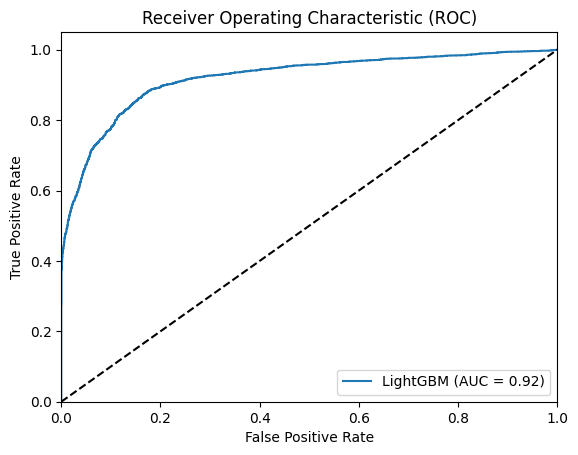

In [ ]:
# Create the best model with the best parameters from LightGBM (c["Best_Params"][3])
best_lgbm_params = c["Best_Params"][3]
best_lgbm_model = LGBMClassifier(**best_lgbm_params, verbosity=-1)
best_lgbm_model.fit(X_train, y_train)

# Model evaluation
y_pred_lgbm = best_lgbm_model.predict(X_test)

# Accuracy
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print("LightGBM Accuracy:", accuracy_lgbm)

# Classification report
print("LightGBM Classification Report:\n", classification_report(y_test, y_pred_lgbm))

# Confusion matrix
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
print("LightGBM Confusion Matrix:\n", cm_lgbm)

# ROC Curve and AUC
y_pred_proba_lgbm = best_lgbm_model.predict_proba(X_test)[:, 1]
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_test, y_pred_proba_lgbm)
roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)

# Plot ROC Curve
plt.figure()
plt.plot(fpr_lgbm, tpr_lgbm, label='LightGBM (AUC = %0.2f)' % roc_auc_lgbm)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Creating a pipeline with Column Transformer for the best model with the best paramater

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import lightgbm as lgb

# Sample DataFrame (replace this with your actual DataFrame)
df = pd.read_csv('your_data.csv')

# Define your features and target
numerical_features = ['enrollee_id', 'city_development_index', 'training_hours']
categorical_features = [
    'city', 'gender', 'relevent_experience', 'enrolled_university',
    'education_level', 'major_discipline', 'experience',
    'company_size', 'company_type', 'last_new_job'
]

target_feature = 'target'

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_features),

        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='Not_specified')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

# Create the full pipeline with LightGBM
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMClassifier(
        num_leaves=25,
        learning_rate=0.22386711658532787,
        n_estimators=164
    ))
])

# Split your data into features and target
X = df.drop(["target"],axis=1)
y = df[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline on your data
pipeline.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['enrollee_id',
                                                   'city_development_index',
                                                   'training_hours']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Not_specified',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['city', 'gender',
                                                   'relevent_experience',
                                                   'enrolled_university',
                                                   'education_level',
                                                   'major_discipline',
                                                   'experience', 'company_size',
                                                   'company_type',
                                                   'last_new_job'])])),
                ('model',
                 LGBMClassifier(learning_rate=0.22386711658532787,
                                n_estimators=164, num_leaves=25))])

# Performing Prediction and Evaulation using pipeline

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.88      0.86      2880
         1.0       0.57      0.49      0.53       952

    accuracy                           0.78      3832
   macro avg       0.70      0.68      0.69      3832
weighted avg       0.77      0.78      0.78      3832

Accuracy: 0.7815762004175365


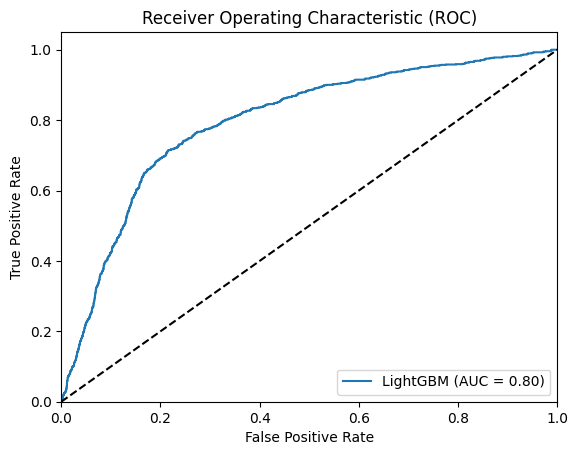

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# ROC Curve and AUC
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label='LightGBM (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Saving the pipeline using pickle

In [ ]:
import pickle

# Save the trained pipeline to a pickle file
with open('trained_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

print("Pipeline saved successfully!")



Pipeline saved successfully!


# Using the pipeline to predictions

In [14]:
import pickle
from sklearn.metrics import classification_report,accuracy_score,roc_curve,roc_curve
import matplotlib.pyplot as plt

# To load the pipeline later, use:
with open('trained_pipeline.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

# Now we can use loaded_pipeline to make predictions or evaluate the model
predictions = loaded_pipeline.predict(X_test)

print (predictions)
# Classification report
print("Classification Report:\n", classification_report(y_test, predictions))

# Accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# ROC Curve and AUC
y_pred_proba = loaded_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_curve(y_test, y_pred_proba)



C:\Users\hemch\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\hemch\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\hemch\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.5.2 whe

[0. 1. 0. ... 0. 0. 0.]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      2877
         1.0       0.77      0.73      0.75       955

    accuracy                           0.88      3832
   macro avg       0.84      0.83      0.83      3832
weighted avg       0.88      0.88      0.88      3832

Accuracy: 0.8789144050104384


# Test based classification
  - lets try a TFIDF and text vectorization method a try

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pickle

In [38]:
# Load the dataset
data = pd.read_csv('aug_train.csv')

pr = Preprocessing(data)
data = pr.handle_nulls()
data = pr.handle_imbalance()


In [39]:
# Prepare the features by concatenating relevant columns into a single string
data['combined_features'] = (
    data['city'].fillna('') + ' ' +
    data['gender'].fillna('') + ' ' +
    data['relevent_experience'].fillna('') + ' ' +
    data['enrolled_university'].fillna('') + ' ' +
    data['education_level'].fillna('') + ' ' +
    data['major_discipline'].fillna('') + ' ' +
    data['experience'].fillna('') + ' ' +
    data['company_size'].fillna('') + ' ' +
    data['company_type'].fillna('') + ' ' +
    data['last_new_job'].fillna('') + ' ' +
    data['training_hours'].astype(str).fillna('')
)

In [40]:
# Define features and target variable
X = data['combined_features']
y = LabelEncoder().fit_transform(data['target'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()


In [42]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_tfidf)
X_test_tensor = torch.FloatTensor(X_test_tfidf)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

In [43]:
# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 2)  # Output layer for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [44]:
# Initialize the model, loss function, and optimizer
model = SimpleNN(input_dim=X_train_tfidf.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [45]:
# Training the model
num_epochs = 58
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor)

    # Compute loss and backpropagate
    loss = criterion(outputs, y_train_tensor)
    loss.backward()

    # Update weights
    optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/58], Loss: 0.6951
Epoch [2/58], Loss: 0.6942
Epoch [3/58], Loss: 0.6933
Epoch [4/58], Loss: 0.6922
Epoch [5/58], Loss: 0.6912
Epoch [6/58], Loss: 0.6903
Epoch [7/58], Loss: 0.6889
Epoch [8/58], Loss: 0.6875
Epoch [9/58], Loss: 0.6862
Epoch [10/58], Loss: 0.6846
Epoch [11/58], Loss: 0.6826
Epoch [12/58], Loss: 0.6805
Epoch [13/58], Loss: 0.6780
Epoch [14/58], Loss: 0.6753
Epoch [15/58], Loss: 0.6720
Epoch [16/58], Loss: 0.6687
Epoch [17/58], Loss: 0.6646
Epoch [18/58], Loss: 0.6603
Epoch [19/58], Loss: 0.6557
Epoch [20/58], Loss: 0.6506
Epoch [21/58], Loss: 0.6453
Epoch [22/58], Loss: 0.6396
Epoch [23/58], Loss: 0.6326
Epoch [24/58], Loss: 0.6257
Epoch [25/58], Loss: 0.6200
Epoch [26/58], Loss: 0.6126
Epoch [27/58], Loss: 0.6048
Epoch [28/58], Loss: 0.5962
Epoch [29/58], Loss: 0.5883
Epoch [30/58], Loss: 0.5808
Epoch [31/58], Loss: 0.5716
Epoch [32/58], Loss: 0.5624
Epoch [33/58], Loss: 0.5531
Epoch [34/58], Loss: 0.5461
Epoch [35/58], Loss: 0.5376
Epoch [36/58], Loss: 0.5275
E

In [46]:
# Evaluate the model's accuracy on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted_classes = torch.max(test_outputs.data, 1)


In [47]:
# Calculate metrics
accuracy = accuracy_score(y_test_tensor.numpy(), predicted_classes.numpy())
roc_auc = roc_auc_score(y_test_tensor.numpy(), torch.softmax(test_outputs, dim=1)[:, 1].numpy())
conf_matrix = confusion_matrix(y_test_tensor.numpy(), predicted_classes.numpy())

print(f'Accuracy: {accuracy:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')

Accuracy: 0.82
ROC-AUC: 0.88


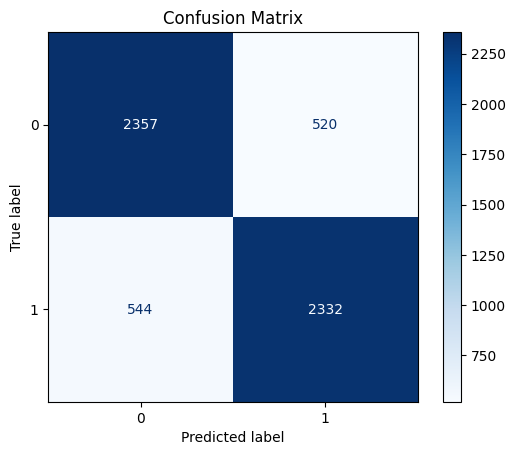

In [48]:
# Display confusion matrix
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [49]:
# Save the model and vectorizer to disk using pickle
with open('text_model.pkl', 'wb') as model_file:
    pickle.dump(model.state_dict(), model_file)  # Save model weights

with open('vectorizer_text.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)  # Save vectorizer

In [50]:
# Function to classify new sentences based on combined features
def classify_features(features):
    features_tfidf = vectorizer.transform([features]).toarray()
    features_tensor = torch.FloatTensor(features_tfidf)

    with torch.no_grad():
        output = model(features_tensor)
        _, predicted_class = torch.max(output.data, 1)

    return predicted_class.item()

# Testing with profile summary

In [51]:
new_features = "A motivated graduate with a STEM background seeking to enter the workforce. With 15 years of general experience, I am eager to apply my skills to a new role within a mid-sized private company. While I lack specific industry experience, my strong academic foundation and adaptability make me a valuable asset to any team."
print(f'The features are classified as: {classify_features(new_features)}')


The features are classified as: 1
